<a href="https://colab.research.google.com/github/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages**

In [ ]:
#Import required packages
% pip install yfinance
% pip install pandas
% pip install tabula-py
% pip install kaggle

import matplotlib.pyplot as plt
import tabula
import pandas as pd
import io
import os
import json
import zipfile
from google.colab import files
from google.colab import data_table

In [ ]:
#cloning github repository
!git clone https://github.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah.git

fatal: destination path 'Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah' already exists and is not an empty directory.


# **Extract**

In [ ]:
#Importing Kaggle Api json file using aslisabanci's code from github as a reference

#Importing dataset called covid19-indonesia created by user hendratno
#!kaggle datasets download -d hendratno/covid19-indonesia
!pwd

#!mkdir -p ~/.kaggle #create the .kaggle directory and put your credentials json file into it
#!cp kaggle.json ~/.kaggle/

/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah
/root


In [59]:
#COVID_df is the dataframe that contains all the information - will be used for timeseries
#Reads in the csv from the URL 
file_path_OWID = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
file_path_COVID_OPEN_DATA = "https://storage.googleapis.com/covid19-open-data/v2/by-sex.csv"
file_path_GRS = "https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"
file_path_demographics = "https://storage.googleapis.com/covid19-open-data/v2/demographics.csv"
file_path_geography = "https://storage.googleapis.com/covid19-open-data/v2/geography.csv"
#file_path_IQ = "https://raw.githubusercontent.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/main/countriesByIQ.csv"
#file_path_PR = "https://raw.githubusercontent.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/main/povertyRate.csv"
file_path_IQ = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/countriesByIQ.csv"
file_path_PR = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/povertyRate.csv"
file_path_index = "https://storage.googleapis.com/covid19-open-data/v2/index.csv"
file_path_indonesia = "/content/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/covid_19_indonesia_time_series_all.csv"

file_path_epidemiology = "https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv"


#COVID_df is the dataframe that contains all the information - will be used for timeseries
#Reads in the csv from each respective URL
COVID_df = pd.read_csv(file_path_OWID)
index_df = pd.read_csv(file_path_index)
demographics_df = pd.read_csv(file_path_demographics)
geo_df = pd.read_csv(file_path_geography)
iq_per_country_df = pd.read_csv(file_path_IQ)
poverty_rate_df = pd.read_csv(file_path_PR)
indonesia_df = pd.read_csv(file_path_indonesia)
worldwide_ts_df = pd.read_csv(file_path_epidemiology)
GR_df = pd.read_csv(file_path_GRS)


worldwide_ts_df.fillna(0, inplace=True)
#data_table.DataTable(indonesia_ts_df)
data_table.DataTable(worldwide_ts_df.loc[worldwide_ts_df.key.str.startswith("ID_", na=False)])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Clean**

**Lookups, Validations, Filters, Translations**


In [61]:
#

# **Transform**

In [37]:
#current_cases_df = Most Current COVID-19 Cases. This dataframe will have the most current
#COVID_19 total cases for each country
from datetime import datetime, timedelta

#Conver the format of "date" to Date
COVID_df['date'] = pd.to_datetime(COVID_df.date)

#Remove unwanted columns
COVID_df = COVID_df.drop(['reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions',
               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_cases_smoothed',
               'new_deaths_smoothed', 'new_cases_smoothed_per_million','new_deaths_smoothed_per_million','new_tests_smoothed', 'new_tests_smoothed_per_thousand',
               'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million', 'female_smokers', 'male_smokers'], axis=1)

#Add daily percentage change as daily_%_change

COVID_df
#Change datas with NaN to 0


iso_code continent  ... life_expectancy human_development_index
0          AFG      Asia  ...           64.83                   0.498
1          AFG      Asia  ...           64.83                   0.498
2          AFG      Asia  ...           64.83                   0.498
3          AFG      Asia  ...           64.83                   0.498
4          AFG      Asia  ...           64.83                   0.498
...        ...       ...  ...             ...                     ...
62234      ZWE    Africa  ...           61.49                   0.535
62235      ZWE    Africa  ...           61.49                   0.535
62236      ZWE    Africa  ...           61.49                   0.535
62237      ZWE    Africa  ...           61.49                   0.535
62238      ZWE    Africa  ...           61.49                   0.535

[62239 rows x 36 columns]

In [38]:
#Get yesterday's date as there may be a delay in the update of the dataset used here
yesterday = datetime.today() - timedelta(2)

#Add each country's most recent data and add it into current_cases_df
current_total_cases_df = COVID_df.loc[(COVID_df['date'].dt.date.astype(str) == yesterday.strftime('%Y-%m-%d'))]

#Reset the index for current_cases_df
current_total_cases_df = current_total_cases_df.reset_index(drop=True)

current_total_cases_df.loc[current_total_cases_df['location'] == "World"]

iso_code continent  ... life_expectancy human_development_index
188  OWID_WRL       NaN  ...           72.58                     NaN

[1 rows x 36 columns]

# **Load**



# **COVID-19 General Data Pre-processing**


**Current Cases**

**Create new dataframe to hold only the most recent data**

**Function to get the date of the first detected COVID-19 case/s for each country**

In [ ]:
def get_first_case_date(country):
  date = ""
  first_case = COVID_df.loc[(COVID_df['location'] == country) & (COVID_df['total_cases'] > 0)]
  if len(first_case) > 0:
    date = first_case['date'].iloc[0]
  else:
    date = "No such country"

  return date

get_first_case_date("Japan")

Timestamp('2020-01-22 00:00:00')

# **Government Response and Stringency**

In [ ]:

#Change data types for Date column into date type
GR_df['Date'] = pd.to_datetime(GR_df['Date'].astype(str), format='%Y%m%d')


GR_df = GR_df.loc[(GR_df['CountryName'] == "Indonesia") & (GR_df['Date'] >= "2020-02-02")]
GR_df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CountryName  ... EconomicSupportIndexForDisplay
46952   Indonesia  ...                            0.0
46953   Indonesia  ...                            0.0
46954   Indonesia  ...                            0.0
46955   Indonesia  ...                            0.0
46956   Indonesia  ...                            0.0
...           ...  ...                            ...
47306   Indonesia  ...                           37.5
47307   Indonesia  ...                           37.5
47308   Indonesia  ...                           37.5
47309   Indonesia  ...                           37.5
47310   Indonesia  ...                           37.5

[359 rows x 49 columns]

# **COVID-19 per Continent Data Pre-Processing + Data Visualisation**


Creating a dataframe for each continent

**Exploring Columns**

In [ ]:
#current_cases_df['continent'].value_counts()

**Function to get time series data for each continent and country**

In [ ]:
timeseries_country_df = COVID_df.copy()
timeseries_country_df

iso_code continent  ... life_expectancy human_development_index
0          AFG      Asia  ...           64.83                   0.498
1          AFG      Asia  ...           64.83                   0.498
2          AFG      Asia  ...           64.83                   0.498
3          AFG      Asia  ...           64.83                   0.498
4          AFG      Asia  ...           64.83                   0.498
...        ...       ...  ...             ...                     ...
62076      ZWE    Africa  ...           61.49                   0.535
62077      ZWE    Africa  ...           61.49                   0.535
62078      ZWE    Africa  ...           61.49                   0.535
62079      ZWE    Africa  ...           61.49                   0.535
62080      ZWE    Africa  ...           61.49                   0.535

[62081 rows x 36 columns]

**Calculates data to be added into the current_COVID_df dataframe**

In [ ]:
#This function returns a dataframe with the most current COVID-19 data worldwide
current_COVID_df = current_total_cases_df

def calculate_data(df):
  #Add CFR (Case Fatality Rate) column
  # no of deaths/no of cases
  df['CFR'] = df.total_deaths / df.total_cases
  #Add MR (Mortality Rate) column
  # no of deaths/populataion
  df['MR'] = df.total_deaths / df.population
  #add number of cases per population rate column
  # no of cases/population
  df['cases_per_population'] = df.total_cases / df.population
  return df

current_COVID_df = calculate_data(current_COVID_df)

**Adds in external data such as:**

1.   Longitude, Latitude, Rural and Urban Area - Geography
2.   Urban, Rural, Largest City Population - Demographics
4.   Intelligence Quotient
5.   Poverty Rate 
6.   Median Income




**Pre-process external datasets**

**Merge demographics with current cases**

In [ ]:
index_df.dropna(subset = ["datacommons"], inplace=True)

index_df['key'] = index_df['key'].astype('str')
index_df = index_df.loc[index_df['key'].str.len() == 2]

index_copy = index_df.copy()
index_copy.reset_index(drop=True)
index_copy = index_copy[['key', 'country_name']]

In [ ]:
#geo_df
iq_df = iq_per_country_df.copy()
iq_df['country'] = iq_df['country'].str.capitalize() 
iq_df = iq_df.drop(['rank', 'pop2020'], axis=1)
iq_df = iq_df.rename(columns={'country': 'country_name',
                              'iq': 'average_iq'})
iq_df = iq_df.sort_values('country_name')
iq_df

country_name  average_iq
107  Afghanistan          84
58       Albania          90
119      Algeria          83
22       Andorra          98
169       Angola          68
..           ...         ...
104    Venezuela          84
46       Vietnam          94
92         Yemen          85
135       Zambia          79
122     Zimbabwe          82

[184 rows x 2 columns]

In [ ]:
pr_df = poverty_rate_df.copy()
pr_df = pr_df.drop(['pop2020'], axis=1)
pr_df = pr_df.sort_values('country')
pr_df = pr_df.rename(columns={'povertyRate': 'poverty_rate', 
                              'country': 'country_name'})
pr_df

country_name  poverty_rate
148  Afghanistan          54.5
37       Albania          14.3
6        Algeria           5.5
112       Angola          32.3
120    Argentina          35.5
..           ...           ...
114    Venezuela          33.1
10       Vietnam           6.7
142        Yemen          48.6
147       Zambia          54.4
124     Zimbabwe          38.3

[162 rows x 2 columns]

In [ ]:
demog = demographics_df.copy()
demog = demog.merge(index_copy, how='inner', on='key')

In [ ]:
columns = ['country_name','rural_population', 'urban_population']
demog_df = demog[columns]
demog_df

country_name  rural_population  urban_population
0                 Andorra            9269.0           67873.0
1    United Arab Emirates         1290785.0         8479744.0
2             Afghanistan        28244481.0         9797273.0
3     Antigua and Barbuda           73318.0           23800.0
4                Anguilla               NaN               NaN
..                    ...               ...               ...
232                 Yemen        18292399.0        10869523.0
233               Mayotte               NaN               NaN
234          South Africa        19408553.0        39149717.0
235                Zambia         9989317.0         7871713.0
236              Zimbabwe         9928163.0         4717305.0

[237 rows x 3 columns]

**Merging demography dataframe to current_COVID_df**

In [ ]:
COVID_current_merge = current_COVID_df.copy()

cur_columns = ['iso_code', 'location', 'total_cases', 'total_deaths',
           'total_cases_per_million', 'total_deaths_per_million', 'population', 
           'population_density','gdp_per_capita', 'life_expectancy', 
           'human_development_index']

columns_fillna = ['total_cases', 'total_deaths','total_cases_per_million', 
                  'total_deaths_per_million', 'population', 'population_density',
                  'gdp_per_capita', 'life_expectancy', 'human_development_index']

COVID_current_merge = COVID_current_merge[cur_columns]
COVID_current_merge = COVID_current_merge.rename(columns={'location': 'country_name'})

COVID_current_merge = COVID_current_merge.merge(demog_df, how='inner', on='country_name')
COVID_current_merge.drop_duplicates(subset='country_name', keep = 'last', inplace = True)

COVID_current_merge = COVID_current_merge.merge(pr_df, how='inner', on='country_name')
COVID_current_merge = COVID_current_merge.merge(iq_df, how='inner', on='country_name')

#Replace NaNs from the current_covid_df with 0
for column in columns_fillna:
  COVID_current_merge[column] = COVID_current_merge[column].fillna(0)

#Remove records with NaNs in columns rural_population and urban_population

data_table.DataTable(COVID_current_merge)

In [ ]:
twnty_population = COVID_current_merge.loc[COVID_current_merge['population'] > 19000000].sum().population
world_population = current_total_cases_df.loc[current_total_cases_df['location'] == "World"].population

percentage = (twnty_population/world_population)*100

print(percentage)


188    80.679324
Name: population, dtype: float64


**Function to get current cases for each continent and country**



# **Getters**

In [ ]:
def get_dates():
  date_df = timeseries_country_df.copy()
  date_df.drop_duplicates(subset ="date", keep = 'last', inplace = True)
  dates = date_df.date.dt.strftime('%Y-%m-%d').unique()
  
  return dates

def get_timeseries_per_country(country):
  ts_df = timeseries_country_df.loc[(timeseries_country_df['location'] == country)]
  ts_df = ts_df.reset_index(drop=True)
  ts_df = ts_df.set_index('date')

  return ts_df

def get_timeseries_per_continent(continent):
  
  dates = get_dates()

  column_names = ['date', 'continent', 'continent_total_cases', 'continent_total_deaths',  'continent_total_cases_per_million', 'continent_total_deaths_per_million']
  continent_timeseries_cases_df = pd.DataFrame(columns = column_names)

  for date in dates:
    ts_df = COVID_df.loc[(COVID_df['continent'] == continent)].copy()
    #Gets the total number of cases in a continent
    continent_total_cases = ts_df.loc[(ts_df.date == date, 'total_cases')].sum()
    #Gets the total number of deaths in a continent
    continent_total_deaths = ts_df.loc[(ts_df.date == date, 'total_deaths')].sum()
    #Gets the total number of cases per million in a continent
    continent_total_cases_per_million = ts_df.loc[(ts_df.date == date, 'total_cases_per_million')].sum()
    #Gets the total number of cases per million in a continent
    continent_total_deaths_per_million = ts_df.loc[(ts_df.date == date, 'total_deaths_per_million')].sum()
    
    #Append df2 into continent_timeseries_cases_df
    df2 = pd.DataFrame({"date":[date], 
                        "continent":[continent],
                        'continent_total_cases': [continent_total_cases],
                        'continent_total_deaths': [continent_total_deaths],
                        'continent_total_cases_per_million': [continent_total_cases_per_million],
                        'continent_total_deaths_per_million': [continent_total_deaths_per_million]}) 
    
    continent_timeseries_cases_df = continent_timeseries_cases_df.append(df2, ignore_index = True)

  continent_timeseries_cases_df = continent_timeseries_cases_df.reset_index(drop=True)
  continent_timeseries_cases_df = continent_timeseries_cases_df.set_index('date')

  return continent_timeseries_cases_df

#Delete this later on
#only used to check if the function works correctly
asia_ts = get_timeseries_per_continent("Asia")
europe_ts = get_timeseries_per_continent("Europe")
africa_ts = get_timeseries_per_continent("Africa")
na_ts = get_timeseries_per_continent("North America")
sa_ts = get_timeseries_per_continent("South America")
oceania_ts = get_timeseries_per_continent("Oceania")
#Delete this later on

In [ ]:
data_table.DataTable(oceania_ts)

In [ ]:
#Get most current COVID-19 data per Continent
def get_current_cases_continent(continents):
  
  column_names = ['continent', 'continent_total_cases', 'continent_total_deaths', 
                  'continent_total_cases_per_million', 'continent_total_deaths_per_million',
                  'average_CFR_per_continent', 'average_MR_per_continent', 'average_continent_cases_per_population']

  continent_cases_df = pd.DataFrame(columns = column_names)

  for continent in continents:
    current_cases_df = current_COVID_df.loc[(current_COVID_df['continent'] == continent)].reset_index(drop=True)
    #Gets the total number of cases in a continent
    continent_total_cases = current_cases_df['total_cases'].sum()
    #Gets the total number of deaths in a continent
    continent_total_deaths = current_cases_df['total_deaths'].sum()
    #Gets the total number of cases per million in a continent
    continent_total_cases_per_million = current_cases_df['total_cases_per_million'].sum()
    #Gets the total number of cases per million in a continent
    continent_total_deaths_per_million = current_cases_df['total_deaths_per_million'].sum()
    #Gets the average CFR of a continent
    average_CFR_per_continent = current_cases_df['CFR'].sum()/current_cases_df['location'].count()
    #Gets the average MR of a continent
    average_MR_per_continent = current_cases_df['MR'].sum()/current_cases_df['location'].count()
    #Gets the average cases per population in each continent
    average_continent_cases_per_population = current_cases_df['cases_per_population'].sum()/current_cases_df['location'].count()
    #Drop all duplicates except 1
    current_cases_df.drop_duplicates(subset ="continent", keep = 'last', inplace = True)
    #Drop all columns except continent, continent_total_cases, continent_total_deaths
    #Append df2 into continent_timeseries_cases_df
    df2 = pd.DataFrame({'continent':[continent],
                        'continent_total_cases': [continent_total_cases],
                        'continent_total_deaths': [continent_total_deaths],
                        'continent_total_cases_per_million': [continent_total_cases_per_million],
                        'continent_total_deaths_per_million': [continent_total_deaths_per_million],
                        'average_CFR_per_continent': [average_CFR_per_continent],
                        'average_MR_per_continent': [average_MR_per_continent],
                        'average_continent_cases_per_population': [average_continent_cases_per_population]}) 
    #Adds each continent df to continent_cases_df 
    continent_cases_df = continent_cases_df.append(df2, ignore_index = True)

  return continent_cases_df

#Get most current total COVID-19 data per country
def get_current_cases_country(country):
  current_cases_df = current_COVID_df.loc[(current_COVID_df['location'] == country)].reset_index(drop=True)
  return current_cases_df

#This function takes in an array of countries in String and
#outputs a barchart comparing the total number of COVID-19 cases
#index: 1 - total cases
#       2 - total deaths
#       5 - total cases per million
#       6 - total deaths per million
#       5 - CFR
#       6 - MR
#       7 - cases per population
def bar_chart_compare_countries(countries, index):
  if len(countries) > 0:
    if index == 1:
      for country in countries:
          current_cases = get_current_cases_country(country).total_cases
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Cases')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Cases')
      plt.show()
    elif index == 2:
      for country in countries:
          current_cases = get_current_cases_country(country).total_deaths
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Deaths Cases')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Deaths')
      plt.show()
    elif index == 3:
      for country in countries:
          current_cases = get_current_cases_country(country).total_cases_per_million
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Cases per Million')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Cases per million')
      plt.show()
    elif index == 4:
      for country in countries:
          current_cases = get_current_cases_country(country).total_deaths_per_million
          plt.barh(country, current_cases, align='center', alpha=0.5)

      plt.xlabel('Total Number of Deaths Cases per Million')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Confirmed Deaths per Million')
      plt.show()
    elif index == 5:
      for country in countries:
          CFR = get_current_cases_country(country).CFR * 100
          plt.barh(country, CFR, align='center', alpha=0.5)

      plt.xlabel('CFR %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current CFR')
      plt.show()
    elif index == 6:
      for country in countries:
          MR = get_current_cases_country(country).MR * 100
          plt.barh(country, MR, align='center', alpha=0.5)

      plt.xlabel('MR %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current MR')
      plt.show()
    elif index == 7:
      for country in countries:
          MR = get_current_cases_country(country).cases_per_population * 100
          plt.barh(country, MR, align='center', alpha=0.5)

      plt.xlabel('Cases per population %')
      plt.ylabel('Countries')
      plt.tight_layout()
      plt.title('Current Cases per Population')
      plt.show()
    else:
      print("index was not inputted or non-existent")
  else:
    print("No countries were inputted")
  #End of function

#This function takes in an array of countries in String and
#outputs a barchart comparing the total number of COVID-19 cases
def bar_chart_compare_cases_continents(continents):
  ts_columns = ['continent', 'continent_total_cases']

  continent_df = get_current_cases_continent(continents)

  for continent in continents:
      continent_total_cases = continent_df.loc[(continent_df['continent'] == continent)].continent_total_cases
      plt.barh(continent, continent_total_cases, align='center', alpha=0.5)

  plt.xlabel('Total Number of Cases')
  plt.ylabel('Continents')
  plt.tight_layout()
  plt.title('Current Confirmed Cases per Continent')
  plt.show()
  #End of function

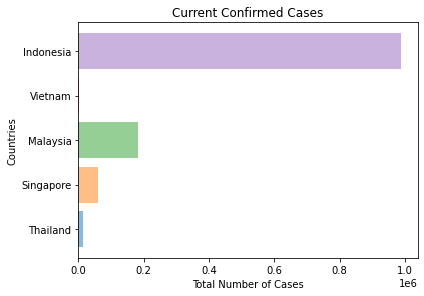

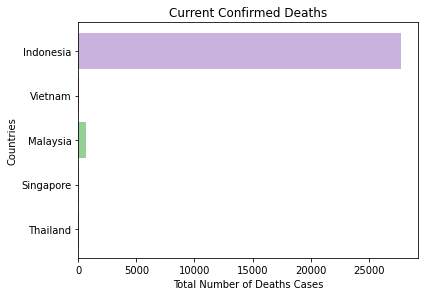

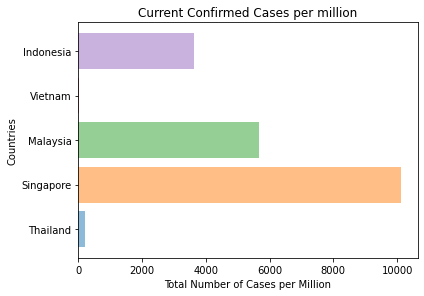

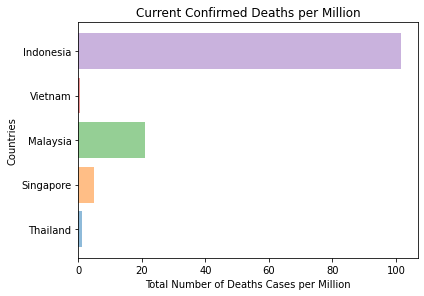

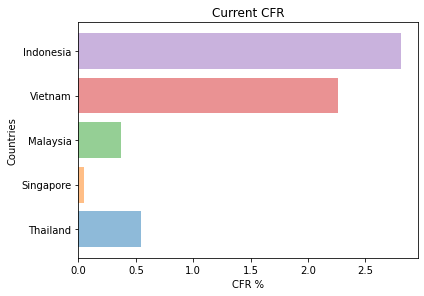

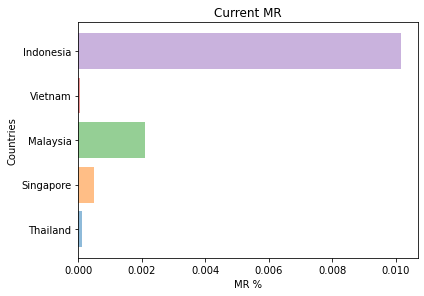

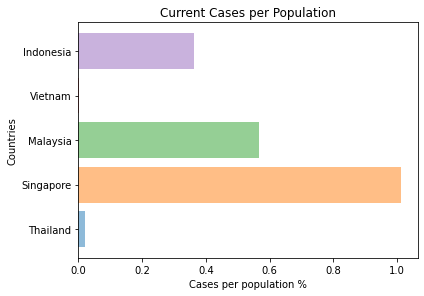

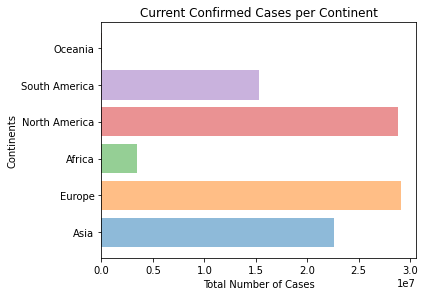

iso_code continent   location  ...       CFR        MR  cases_per_population
0      SGP      Asia  Singapore  ...  0.000489  0.000005              0.010138

[1 rows x 39 columns]

In [ ]:
#List of ASEAN countries used for this research
ASEAN = ['Thailand', 'Singapore', 'Malaysia', 'Vietnam', 'Indonesia']

#List of all continents
continents = current_COVID_df.continent.unique().tolist()[:-1]

bar_chart_compare_countries(ASEAN,1)
bar_chart_compare_countries(ASEAN,2)
bar_chart_compare_countries(ASEAN,3)
bar_chart_compare_countries(ASEAN,4)
bar_chart_compare_countries(ASEAN,5)
bar_chart_compare_countries(ASEAN,6)
bar_chart_compare_countries(ASEAN,7)

bar_chart_compare_cases_continents(continents)

get_current_cases_country("Singapore")

In [ ]:
#Gets top 10 most affected countries

#Gets top 10 countries with most deaths

#Gets top 10 most affected countries/million

#Gets top 10 countries with most deaths/million


# **Data Visualisation - Indonesia vs Other Countries**

In [ ]:
#Time Series cumulative data visualisation
#dv = data visualisation
#parameter name meaning name of country or continent
#parameter level: 1 - country 
#                 2 - continent
def dv_cases_deaths(name, level):
  if name:
    if level == 1:
      ts_columns = ['total_cases', 'total_deaths']

      timeseries_df = get_timeseries_per_country(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    elif level == 2:
      ts_columns = ['continent_total_cases', 'continent_total_deaths']

      timeseries_df = get_timeseries_per_continent(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    else:
      print("Level is not specified. Do you want to visualise a country or a continent?")
  else:
    print("Name is not specified. Please specify the name of a country/continent")

#Time Series cumulative data visualisation
#dv = data visualisation
#parameter name meaning name of country or continent
#parameter level: 1 - country 
#                 2 - continent
def dv_cases_deaths_per_million(name, level):
  if name:
    if level == 1:
      ts_columns = ['total_cases_per_million', 'total_deaths_per_million']

      timeseries_df = get_timeseries_per_country(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    elif level == 2:
      ts_columns = ['continent_total_cases', 'continent_total_deaths']

      timeseries_df = get_timeseries_per_continent(name)

      new_cases_num_df = timeseries_df[ts_columns]
      new_cases_num_df.plot()

      #plt.plot(timeseries_df.total_cases, color='blue')
      #plt.plot(timeseries_df.total_deaths, color='orange')
      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases and Deaths in {}'.format(name))
      plt.show()
    else:
      print("Level is not specified. Do you want to visualise a country or a continent?")
  else:
    print("Name is not specified. Please specify the name of a country/continent")

In [ ]:
#Time Series cumulative data visualisation as a percentage to the country's population - Indonesia vs other ASEAN countries
#parameter 'countries' needs a list
#parameter 'status' needs either: 'cases'
#                                 'deaths'
def dv_compare_timeseries_between_countries(countries, status):
  if len(countries)>0:
    if status == "cases":
      ts_columns = ['total_cases']
      for country in countries:
        timeseries_df = get_timeseries_per_country(country)
        new_cases_num_df = timeseries_df[ts_columns]
        plt.plot(new_cases_num_df, label = country)

      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Cases in {}'.format(countries))
      plt.legend(loc="upper left")
      plt.show()
    elif status == "deaths":
      ts_columns = ['total_deaths']
      for country in countries:
        timeseries_df = get_timeseries_per_country(country)
        new_cases_num_df = timeseries_df[ts_columns]
        plt.plot(timeseries_df.total_deaths, label = country)

      plt.xlabel('Date')
      plt.ylabel('Population')
      plt.title('Cumulative Confirmed Deaths in {}'.format('countries'))
      plt.legend(loc="upper left")
      plt.show()
    else:
      print("Does not exist")
  else:
    print("Country is not inputted")
  

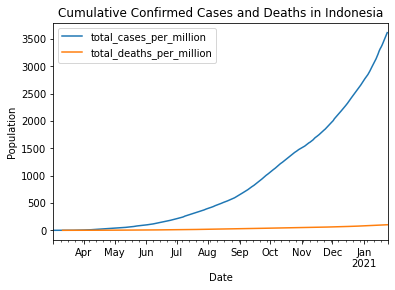

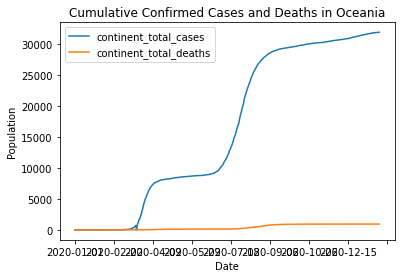

In [ ]:
dv_cases_deaths_per_million("Indonesia", 1)
dv_cases_deaths_per_million("Oceania", 2)

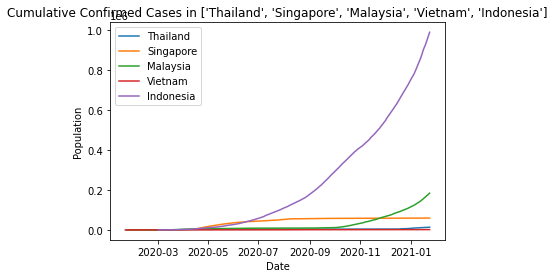

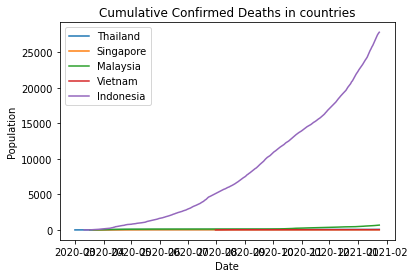

In [ ]:
dv_compare_timeseries_between_countries(ASEAN, "cases")
dv_compare_timeseries_between_countries(ASEAN, "deaths")

In [ ]:
#Find countries with similar GDP per Capita, HDI, and Population Density and Climate
#Similarity should be around +- 10% of the chosen country's data
#index - 1: GDP per Capita
#        2: HDI
#        3: Population Density
#        4: 
#Then returns an array of the countries that are most similar to the inputted country

def get_similar_countries(country, index):
  #Calls the function get_current_cases_country to get the most current data
  #of the country inputted in the parameter
  country_df = get_current_cases_country(country)

  #Gets the country's population density
  country_pd = country_df.population_density.astype(float).iloc[0]
  #Gets the country's GDP per capita
  country_GDP = country_df.gdp_per_capita.astype(float).iloc[0]
  #Gets the country's HDI
  country_HDI = country_df.human_development_index.astype(float).iloc[0]
  #print("{}'s HDI: {}".format(country, country_HDI))

  #Upper and lower limits to find similar data. 1.1 used so that it will get
  #countries with 5% more of the country's data and 0.9 is used so that it will
  #get countries with 5% less of the country's data
  upper = 1.05
  lower = 0.95

  index_factor = [1,2,3]

  similar_countries_df = current_COVID_df

  if any(i in index for i in index_factor):
    for i in index:
      if i == 1:
        lower_limit_GDP = country_GDP * lower
        upper_limit_GDP = country_GDP * upper
        similar_countries_df = similar_countries_df.loc[(similar_countries_df.gdp_per_capita >= lower_limit_GDP) & (similar_countries_df.gdp_per_capita <= upper_limit_GDP)]

        #subtract the other countries' GDP to the inputted country's GDP - new column named 'delta_GDP'
        #similar_countries_df['delta_GDP'] = similar_countries_df.gdp_per_capita - country_GDP
      if i == 2:
        lower_limit_PD = country_pd * lower
        upper_limit_PD = country_pd * upper
        similar_countries_df = similar_countries_df.loc[(similar_countries_df.population_density >= lower_limit_PD) & (similar_countries_df.population_density <= upper_limit_PD)]

        #similar_countries_df['delta_PD'] = similar_countries_df.population_density - country_PD
      if i == 3:
        lower_limit_HDI = country_HDI * lower
        upper_limit_HDI = country_HDI * upper
        similar_countries_df = similar_countries_df.loc[(similar_countries_df.human_development_index >= lower_limit_HDI) & (similar_countries_df.human_development_index <= upper_limit_HDI)]

        #similar_countries_df['delta_HDI'] = similar_countries_df.human_development_index - country_HDI
  else:
    print("No such index")
    similar_countries_df = similar_countries_df.iloc[0:0]

  similar_countries_df = similar_countries_df.reset_index(drop=True)
  similar_countries_df = similar_countries_df.set_index('date')

  return similar_countries_df.location.tolist()

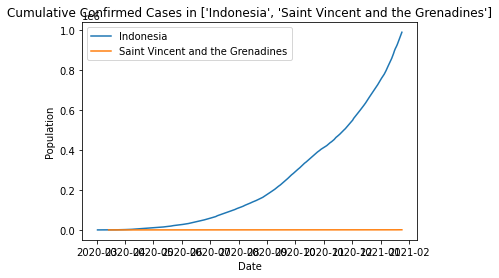

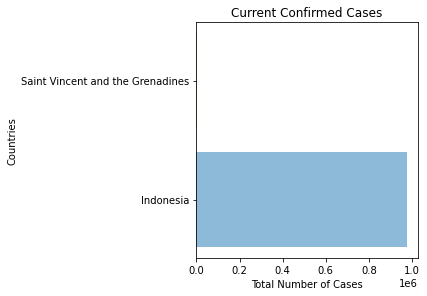

In [ ]:
indices = [1,3]
countries = get_similar_countries("Indonesia", indices)
dv_compare_timeseries_between_countries(countries, "cases")
bar_chart_compare_cases_countries(countries, 1)

# **Linear Regression, Correlation and Confidence Test**

In [ ]:
#lr_df meaning linear regression dataframe
linear_regression_df = COVID_current_merge.copy()


In [ ]:
correlation_df = COVID_current_merge.copy()

#**Stocks Data Pre-Processing**

In [ ]:
import yfinance as yf
import pandas as pd


**Pre-Processing the list of companies from IDX**

In [ ]:
#Gets company list listed in IDX from IDX's (Indonesia Stock Exchange) website
#file_path = 'https://idx.co.id/media/8127/09_listed-companies-by-entry-point-2020-en.pdf'

#Converts and downloads the content from PDF to CSV so it can be uploaded to github
#and use pd.read_csv instead of calling tabula
#tabula.convert_into(file_path, 'company_list.csv',stream=True, pages='all')

In [ ]:
#Reads in the CSV file from github
file_path = 'https://raw.githubusercontent.com/filbertmiko/Analysis-of-COVID-19-and-its-Impact-on-IHSG-and-Rupiah/main/company_list.csv'

#Convert it into a pandas dataframe
company_list = pd.read_csv(file_path)

In [ ]:
#Pre-process dataframe
#Detele any NaNs
idx_company_list = company_list.dropna()

#Filter out unwanted records
idx_companies = idx_company_list[idx_company_list.No != "No"]

#Convert column's data type
convert_dict = {'Kode': str, 
                'Nama Perusahaan': str
               } 
  
idx_companies = idx_companies.astype(convert_dict) 

idx_companies = idx_companies.reset_index()

#Drop unwanted columns
idx_companies = idx_companies.drop(['index','No','Entry Point', 'Sektor', 'Subsektor'], axis=1)


#Rename columns
idx_companies = idx_companies.rename(columns={"Kode": "Symbol", "Nama Perusahaan": "Name"}, errors="raise")

In [ ]:
#Add IDX's extension for yfinance
#Example -> BBCA becomes BBCA.JK

JKSE_symbol = ".JK"
idx_companies['Symbol'] = idx_companies['Symbol'].astype(str) + JKSE_symbol

In [ ]:
#Get information for the inputted Symbol and
#Turns the returned values (dict) to dataframe

#Use a for loop to loop through the company list dataframe and then for each
#iteration, call the function, and combine the returned df to the bigger df
def turn_info_into_df(ticker):
  #Get information for the inputted Symbol and
  symbol = yf.Ticker(ticker)

  keys = [*symbol.info.keys()]
  values = [*symbol.info.values()]

  items = [keys, values]
  df = pd.DataFrame(items)
  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  #df1 = df[['a', 'b']]
  df = df[['sector', 'city', 'longBusinessSummary', 'country', 'industry', 'previousClose']]
  
  return(df)

turn_info_into_df("BBCA.JK")

0              sector     city  ...        industry previousClose
1  Financial Services  Jakarta  ...  Banks—Regional         35400

[1 rows x 6 columns]

In [ ]:
#Combine table from idx_companies to the stock's details taken from yfinance